In [2]:
"""
@description: 基于轨道交通数据进行的，时间序列分析
@Author: LJ.Michale
@Date: 2021-11-20
@Location: 深圳-南山
"""

In [3]:
import pandas as pd          
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [4]:
# #############################  数据集准备  #############################
# 去直接读取用pandas读取csv文本文件，并拷贝一份以备用。
train = pd.read_csv("file:///F:\\datasets\\jetrail\\jetrail_train.csv")
test = pd.read_csv("file:///F:\\datasets\\jetrail\\jetrail_test.csv")
train_org = train.copy()
test_org = test.copy()

In [6]:
train.columns
test.columns

Index(['ID', 'Datetime'], dtype='object')

In [7]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [8]:
test.shape, train.shape

((5112, 2), (18288, 3))

In [9]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [10]:
# 解析日期格式
train['Datetime'] = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
test_org['Datetime'] = pd.to_datetime(test_org.Datetime,format='%d-%m-%Y %H:%M')
train_org['Datetime'] = pd.to_datetime(train_org.Datetime,format='%d-%m-%Y %H:%M')

In [11]:
train.dtypes

ID                   int64
Datetime    datetime64[ns]
Count                int64
dtype: object

In [12]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [13]:
# ############  时间序列数据的特征工程
"""
我们根据实际情况，选用时间戳衍生时间特征。
时间戳虽然只有一列，但是也可以根据这个就衍生出很多很多变量了，具体可以分为三大类：时间特征、布尔特征，时间差特征。
本案例首先对日期时间进行时间特征处理，而时间特征包括年、季度、月、周、天(一年、一月、一周的第几天)、小时、分钟...
因为需要对test, train, test_org, train_org四个数据框进行同样的处理，直接使用for循环批量提取年月日小时等特征。
"""
for i in (test, train, test_org, train_org):
    i['Year'] = i.Datetime.dt.year
    i['Month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour
    #i["day of the week"] = i.Datetime.dt.dayofweek

In [14]:
test.head()

,ID,Datetime,Year,Month,day,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0
1,18289,2014-09-26 01:00:00,2014,9,26,1
2,18290,2014-09-26 02:00:00,2014,9,26,2
3,18291,2014-09-26 03:00:00,2014,9,26,3
4,18292,2014-09-26 04:00:00,2014,9,26,4


In [15]:
"""
时间戳衍生中，另一常用的方法为布尔特征，即：
是否年初/年末
是否月初/月末
是否周末
是否节假日
是否特殊日期
是否早上/中午/晚上
等等
"""
# 下面判断是否是周末，进行特征衍生的布尔特征转换。首先提取出日期时间的星期几。

'\n时间戳衍生中，另一常用的方法为布尔特征，即：\n是否年初/年末\n是否月初/月末\n是否周末\n是否节假日\n是否特殊日期\n是否早上/中午/晚上\n等等\n'

In [16]:
train['day of the week'] = train.Datetime.dt.dayofweek
# 返回给定日期时间的星期几

In [17]:
train.head()

,ID,Datetime,Count,Year,Month,day,Hour,day of the week
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5


In [18]:
# 再判断day of the week是否是周末（星期六和星期日），是则返回1 ，否则返回0
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp = train['Datetime']    
temp2 = train.Datetime.apply(applyer)
train['weekend'] = temp2
train.index = train['Datetime']

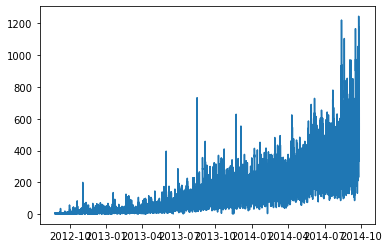

In [19]:
# 对年月乘客总数统计后可视化，看看总体变化趋势。
df = train.drop('ID',1)
ts = df['Count']
plt.plot(ts, label = 'Passenger count')

In [20]:
# #######################  探索性数据分析
# 首先使用探索性数据分析，从不同时间维度探索分析交通系统乘客数量。

In [21]:
"""
年
对年进行聚合，求所有数据中按年计算的每日平均客流量，从图中可以看出，随着时间的增长，每日平均客流量增长迅速。
"""

'\n年\n对年进行聚合，求所有数据中按年计算的每日平均客流量，从图中可以看出，随着时间的增长，每日平均客流量增长迅速。\n'

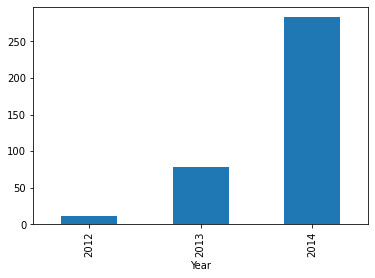

In [22]:
train.groupby('Year')['Count'].mean().plot.bar()

In [23]:
"""
月
对月份进行聚合，求所有数据中按月计算的每日平均客流量，从图中可以看出，春夏季客流量每月攀升，而秋冬季客流量骤减。
"""

'\n月\n对月份进行聚合，求所有数据中按月计算的每日平均客流量，从图中可以看出，春夏季客流量每月攀升，而秋冬季客流量骤减。\n'

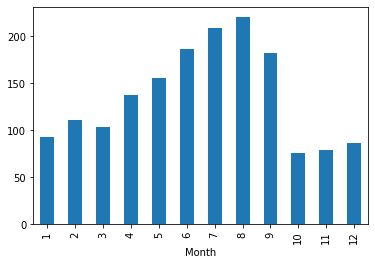

In [24]:
train.groupby('Month')['Count'].mean().plot.bar()

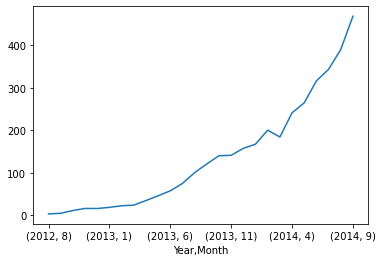

In [25]:
"""
年月
对年月份进行聚合，求所有数据中按年月计算的每日平均客流量，从图可知道，几本是按照平滑指数上升的趋势。
"""
temp = train.groupby(['Year','Month'])['Count'].mean()
temp.plot()# 乘客人数(每月)

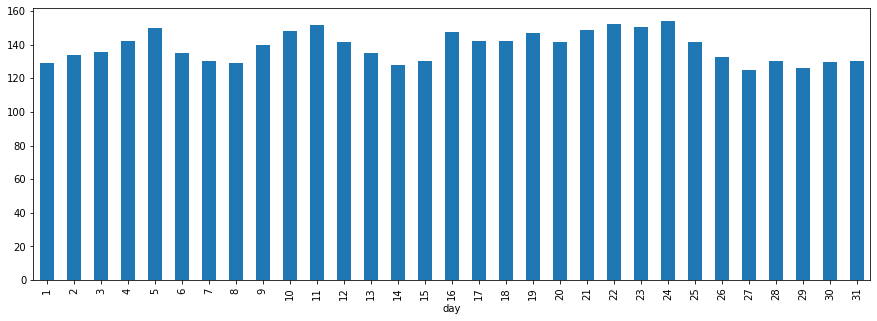

In [26]:
"""
日
对日进行聚合，求所有数据中每月中的每日平均客流量。从图中可大致看出，在5、11、24分别出现三个峰值，该峰值代表了上中旬的高峰期。
"""
train.groupby('day')['Count'].mean(
         ).plot.bar(figsize = (15,5))

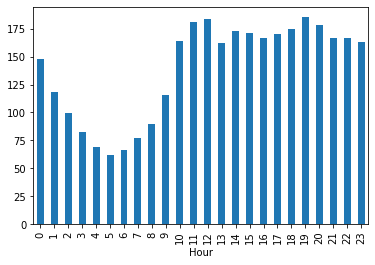

In [27]:
"""
小时
对小时进行聚合，求所有数据中一天内按小时计算的平均客流量，得到了在中(12)晚(19)分别出现两个峰值，该峰值代表了每日的高峰期。
"""
train.groupby('Hour')['Count'].mean().plot.bar()

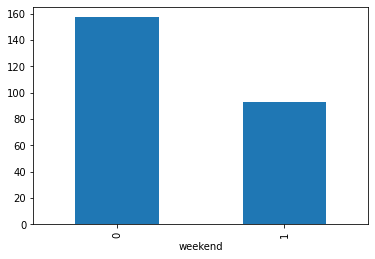

In [28]:
"""
是否周末
对是否是周末进行聚合，求所有数据中按是否周末计算的平均客流量，发现工作日比周末客流量客流量多近一倍，果然大家都是周末都喜欢宅在家里。
"""
train.groupby('weekend')['Count'].mean().plot.bar()

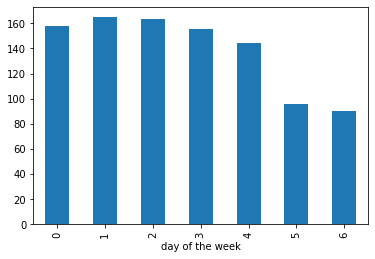

In [29]:
"""
周
对星期进行聚合统计，求所有数据中按是周计算的平均客流量。
"""
train.groupby('day of the week')['Count'].mean().plot.bar()

In [30]:
"""
时间重采样
◎ 重采样(resampling)指的是将时间序列从一个频率转换到另一个频率的处理过程；
◎ 将高频率数据聚合到低频率称为降采样(downsampling)；
◎ 将低频率数据转换到高频率则称为升采样(unsampling)；
"""
train.head()

,ID,Datetime,Count,Year,Month,day,Hour,day of the week,weekend
Datetime,,,,,,,,,
2012-08-25 00:00:00,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1


In [31]:
"""
Pandas中的resample，重新采样，是对原样本重新处理的一个方法，
是一个对常规时间序列数据重新采样和频率转换的便捷的方法。
接下来对训练数据进行对月、周、日及小时多重采样。其实我们分月份进行采样，然后求月内的均值。
事实上重采样，就相当于groupby，只不过是根据月份这个period进行分组。
"""

In [52]:
# 此处需要修改

,Year,Month,day,Hour
Datetime,,,,
2014-09-26,2014.0,9.0,26.0,11.5
2014-09-27,2014.0,9.0,27.0,11.5
2014-09-28,2014.0,9.0,28.0,11.5
2014-09-29,2014.0,9.0,29.0,11.5
2014-09-30,2014.0,9.0,30.0,11.5
...,...,...,...,...
2015-04-22,2015.0,4.0,22.0,11.5
2015-04-23,2015.0,4.0,23.0,11.5
2015-04-24,2015.0,4.0,24.0,11.5


In [33]:
# 重采样后对其进行可视化，直观地看看其变化趋势。

In [34]:
# 对测试数据也进行相同的时间重采样处理。
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
# 换算成日平均值
test = test.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# C换算成日平均值
train = train.resample('D').mean()

D:\software\Anaconda\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
D:\software\Anaconda\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [48]:
test

,ID,Year,Month,day,Hour
Datetime,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5
2014-09-27,18323.5,2014.0,9.0,27.0,11.5
2014-09-28,18347.5,2014.0,9.0,28.0,11.5
2014-09-29,18371.5,2014.0,9.0,29.0,11.5
2014-09-30,18395.5,2014.0,9.0,30.0,11.5
...,...,...,...,...,...
2015-04-22,23291.5,2015.0,4.0,22.0,11.5
2015-04-23,23315.5,2015.0,4.0,23.0,11.5
2015-04-24,23339.5,2015.0,4.0,24.0,11.5


In [53]:
train

,Count,Year,Month,day,Hour,day of the week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0
...,...,...,...,...,...,...,...
2014-09-21,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0
2014-09-22,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0
2014-09-23,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0


In [59]:
"""
划分训练集和验证集
到目前为止，我们有训练集和测试集，实际上，我们还需要一个验证集，用来实时验证和调整训练模型。下面直接用索引切片的方式做处理。
"""
Train = train.loc['2012-08-25':'2014-06-24']
valid = train['2014-06-25':'2014-09-25']

In [60]:
Train

,Count,Year,Month,day,Hour,day of the week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0
...,...,...,...,...,...,...,...
2014-06-20,379.916667,2014.0,6.0,20.0,11.5,4.0,0.0
2014-06-21,220.083333,2014.0,6.0,21.0,11.5,5.0,1.0
2014-06-22,230.833333,2014.0,6.0,22.0,11.5,6.0,1.0


In [61]:
valid

,Count,Year,Month,day,Hour,day of the week,weekend
Datetime,,,,,,,
2014-06-25,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0
2014-06-26,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0
2014-06-27,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0
2014-06-28,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0
2014-06-29,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0
...,...,...,...,...,...,...,...
2014-09-21,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0
2014-09-22,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0
2014-09-23,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0


In [62]:
# ###########################  模型建立
# 数据准备好了，就到了模型建立阶段，这里我们应用多个时间序列预测技术，
# 如朴素法、移动平均方法、简单指数平滑、霍尔特线性趋势法、霍尔特-温特法、ARIMA和SARIMAX模型。

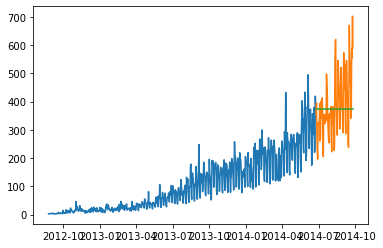

In [66]:
"""
朴素预测法
如果数据集在一段时间内都很稳定，我们想预测第二天的价格，可以取前面一天的价格，预测第二天的值。
这种假设第一个预测点和上一个观察点相等的预测方法就叫朴素预测法(Naive Forecast)

因为朴素预测法用最近的观测值作为预测值，因此他最简单的预测方法。
虽然朴素预测法并不是一个很好的预测方法，但是它可以为其他预测方法提供一个基准。
"""
dd = np.asarray(Train.Count)
# 将结构数据转化为ndarray
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.plot(Train.index, Train['Count'], label = 'Train')
plt.plot(valid.index,valid['Count'], label='Valid')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')

In [67]:
# 模型评价
# 用RMSE检验朴素法的的准确率
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive))
print(rms)

111.79050467496724


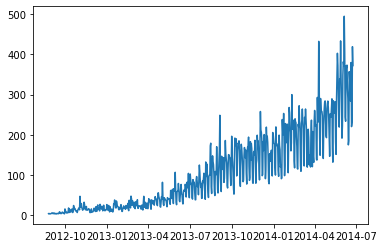

In [69]:
"""
移动平均值法
移动平均法也叫滑动平均法，取前面n个点的平均值作为预测值。
计算移动平均值涉及到一个有时被称为"滑动窗口"的大小值 。使用简单的移动平均模型，
我们可以根据之前数值的固定有限数的平均值预测某个时序中的下一个值。
利用一个简单的移动平均模型，我们预测一个时间序列中的下一个值是基于先前值的固定有限个数“p”的平均值。
"""
# 最近10次观测的移动平均值，即滑动窗口大小为P=10
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] 

# 最近20次观测的移动平均值
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1]

# 最近30次观测的移动平均值
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1]
plt.plot(Train['Count'], label='Train')

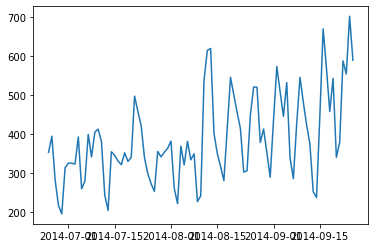

In [70]:
plt.plot(valid['Count'], label='Valid')

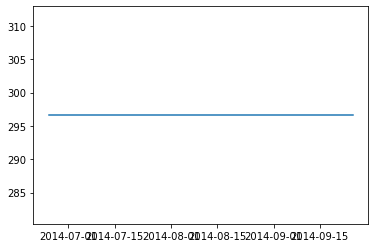

In [71]:
plt.plot(y_hat_avg['moving_avg_forecast'], 
         label='Moving Average Forecast using 50 observations')

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


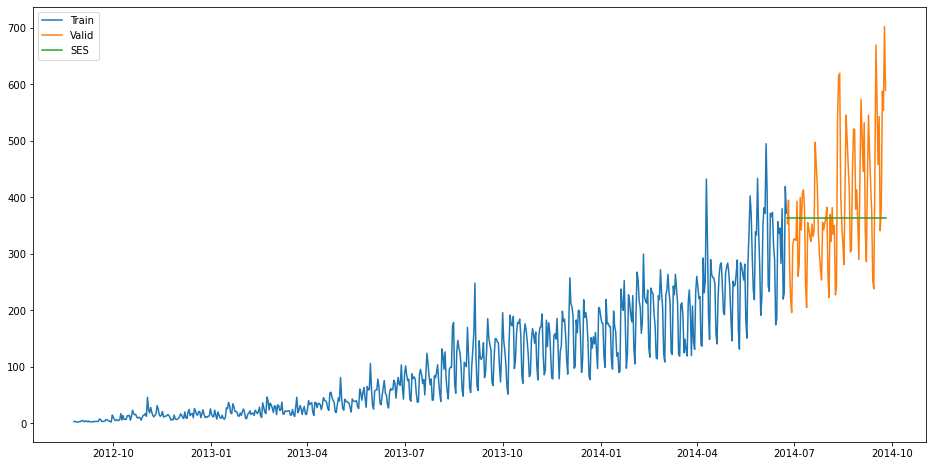

In [72]:
"""
简单指数平滑法
介绍这个之前，需要知道什么是简单平均法(Simple Average），该方法预测的期望值等于所有先前观测点的平均值。
物品价格会随机上涨和下跌，平均价格会保持一致。我们经常会遇到一些数据集，虽然在一定时期内出现小幅变动，但每个时间段的平均值确实保持不变。
这种情况下，我们可以认为第二天的价格大致和过去的平均价格值一致。

简单平均法和加权移动平均法在选取时间点的思路上存在较大的差异：
简单平均法将过去数据一个不漏地全部加以同等利用；
移动平均法则不考虑较远期的数据，并在加权移动平均法中给予近期更大的权重。
我们就需要在这两种方法之间取一个折中的方法，在将所有数据考虑在内的同时也能给数据赋予不同非权重。
简单指数平滑法 (Simple Exponential Smoothing)相比更早时期内的观测值，越近的观测值会被赋予更大的权重，而时间越久远的权重越小。
它通过加权平均值计算出预测值，其中权重随着观测值从早期到晚期的变化呈指数级下降，最小的权重和最早的观测值相关：
"""
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level = 0.6, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize = (16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [73]:
# 模型评价
# 用RMSE检验朴素法的的准确率
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES))
print(rms)

113.43708111884514


D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
D:\software\Anaconda\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  # This is added back by InteractiveShellApp.init_path()


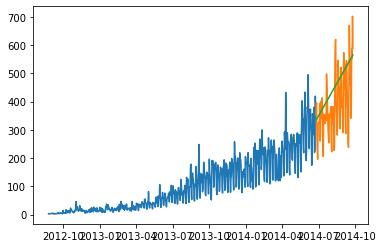

In [74]:
"""
霍尔特线性趋势法
Holts线性趋势模型，该方法考虑了数据集的趋势，即序列的增加或减少性质。
尽管这些方法中的每一种都可以应用趋势：简单平均法会假设最后两点之间的趋势保持不变，
或者我们可以平均所有点之间的所有斜率以获得平均趋势，使用移动趋势平均值或应用指数平滑。
但我们需要一种无需任何假设就能准确绘制趋势图的方法。
这种考虑数据集趋势的方法称为霍尔特线性趋势法，或者霍尔特指数平滑法。
"""
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])
           ).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))

plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')

In [75]:
# 模型评价
# 用RMSE检验朴素法的的准确率
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear))
print(rms)

112.94278345314041


In [84]:
# 由于holts线性趋势，到目前为止具有最好的准确性，我们尝试使用它来预测测试数据集。
predict = fit1.forecast(len(test))
test['prediction'] = predict
# 计算每小时计数的比率
train_org['ratio'] = train_org['Count']/train_org['Count'].sum()
# 按小时计数分组
temp = train_org.groupby(['Hour'])['ratio'].sum()
# # 保存聚合后的数据
# pd.DataFrame(temp, columns =['ratio']).to_csv('file:///F:\\datasets\\jetrail\\GROUPBY.csv')
# temp2 = pd.read_csv('file:///F:\\datasets\\jetrail\\GROUPBY.csv')
# 按日、月、年合并test和test_org
merge = pd.merge(test,test_org, on= ('day','Month','Year'),how = 'left')
merge

,Year,Month,day,Hour_x,prediction,ID,Datetime,Hour_y
0,2014.0,9.0,26.0,11.5,334.650767,18288,2014-09-26 00:00:00,0
1,2014.0,9.0,26.0,11.5,334.650767,18289,2014-09-26 01:00:00,1
2,2014.0,9.0,26.0,11.5,334.650767,18290,2014-09-26 02:00:00,2
3,2014.0,9.0,26.0,11.5,334.650767,18291,2014-09-26 03:00:00,3
4,2014.0,9.0,26.0,11.5,334.650767,18292,2014-09-26 04:00:00,4
...,...,...,...,...,...,...,...,...
5107,2015.0,4.0,26.0,11.5,866.398583,23395,2015-04-26 19:00:00,19
5108,2015.0,4.0,26.0,11.5,866.398583,23396,2015-04-26 20:00:00,20
5109,2015.0,4.0,26.0,11.5,866.398583,23397,2015-04-26 21:00:00,21
5110,2015.0,4.0,26.0,11.5,866.398583,23398,2015-04-26 22:00:00,22


In [89]:
# merge["Hour"] = merge["Hour_y"]
# merge["ID"] = merge["ID_y"]
# merge.head()

KeyError: 'ID_y'

In [93]:
merge = merge.drop(["Month","Datetime","Hour_x","Hour_y"], axis =1)
merge.head()

,day,prediction,ID,Hour
0,26.0,334.650767,18288,0
1,26.0,334.650767,18289,1
2,26.0,334.650767,18290,2
3,26.0,334.650767,18291,3
4,26.0,334.650767,18292,4


D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


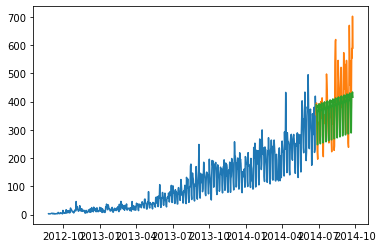

In [94]:
"""
霍尔特-温特法
霍尔特-温特（Holt-Winters）方法，在 Holt模型基础上引入了 Winters 周期项（也叫做季节项），
可以用来处理月度数据（周期 12）、季度数据（周期 4）、星期数据（周期 7）等时间序列中的固定周期的波动行为。
引入多个 Winters 项还可以处理多种周期并存的情况。
"""
# Holts Winter model
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods = 7, trend = 'add', seasonal = 'add',).fit()
y_hat_avg['Holts_Winter'] = fit1.forecast(len(valid))
plt.plot( Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holts_Winter'], label='Holt_Winter')

In [95]:
# 模型评价
# 用RMSE检验朴素法的的准确率
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holts_Winter))
print(rms)

81.93504580749317


In [98]:
# 模型预测
predict=fit1.forecast(len(test))
test['prediction']=predict
predict
# # 按日、月、年合并Test和test_original
# merge=pd.merge(test, test_org, on=('day','Month', 'Year'), how='left')
# merge['Hour']=merge['Hour_y']
# merge=merge.drop(['Year', 'Month', 'Datetime','Hour_x','Hour_y'], axis=1)
# # 通过合并merge和temp2进行预测
# prediction=pd.merge(merge, temp2, on='Hour', how='left')
# # 将比率转换成原始比例
# prediction['Count']=prediction['prediction']*prediction['ratio']*24
# prediction['ID']=prediction['ID_y']
# submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)
# # 转换最终提交的csv格式
# pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt winters.csv')

array([388.68294732, 370.22238715, 356.59411171, 247.88003872,
       247.43163044, 387.28718569, 378.22933604, 392.1770088 ,
       373.71644863, 360.08817319, 251.37410019, 250.92569191,
       390.78124716, 381.72339751, 395.67107027, 377.2105101 ,
       363.58223466, 254.86816167, 254.41975339, 394.27530864,
       385.21745899, 399.16513175, 380.70457158, 367.07629614,
       258.36222314, 257.91381486, 397.76937011, 388.71152046,
       402.65919322, 384.19863305, 370.57035761, 261.85628461,
       261.40787634, 401.26343158, 392.20558193, 406.1532547 ,
       387.69269453, 374.06441908, 265.35034609, 264.90193781,
       404.75749306, 395.69964341, 409.64731617, 391.186756  ,
       377.55848056, 268.84440756, 268.39599928, 408.25155453,
       399.19370488, 413.14137764, 394.68081748, 381.05254203,
       272.33846904, 271.89006076, 411.74561601, 402.68776636,
       416.63543912, 398.17487895, 384.54660351, 275.83253051,
       275.38412223, 415.23967748, 406.18182783, 420.12

In [99]:
"""
迪基-福勒检验
函数执行迪基-福勒检验以确定数据是否为平稳时间序列。
在统计学里，迪基-福勒检验（Dickey-Fuller test）可以测试一个自回归模型是否存在单位根（unit root）。
回归模型可以写为，是一阶差分。测试是否存在单位根等同于测试是否 。
因为迪基-福勒检验测试的是残差项，并非原始数据，所以不能用标准t统计量。我们需要用迪基-福勒统计量。
"""
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    # 确定滚动数据
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    # 会议滚动数据
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # 执行迪基-福勒检验
    print('Results of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'P-value', '#lags used', 'No of Observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

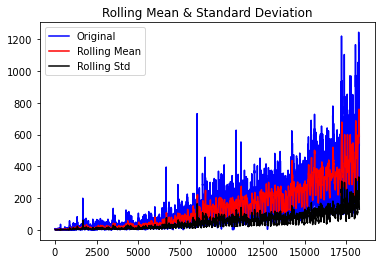

Results of Dickey-Fuller Test: 
Test Statistic                -4.456561
P-value                        0.000235
#lags used                    45.000000
No of Observations used    18242.000000
Critical Value (1%)           -3.430709
Critical Value (5%)           -2.861698
Critical Value (10%)          -2.566854
dtype: float64


In [100]:
# 绘制检验图
test_stationary(train_org['Count'])

In [101]:
"""
移动平均值
在统计学中，移动平均（moving average），又称滑动平均是一种通过创建整个数据集中不同子集的一系列平均数来分析数据点的计算方法。
移动平均通常与时间序列数据一起使用，以消除短期波动，突出长期趋势或周期。
"""
# 对原始数据求对数。
Train_log = np.log(Train['Count'])
valid_log = np.log(Train['Count'])
Train_log.head()

Datetime
2012-08-25    1.152680
2012-08-26    1.299283
2012-08-27    0.949081
2012-08-28    0.882389
2012-08-29    0.916291
Freq: D, Name: Count, dtype: float64

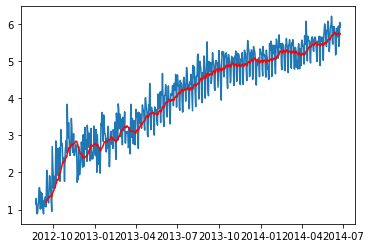

In [102]:
# 绘制移动平均值曲线
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')
plt.show()

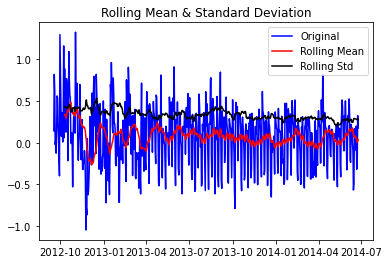

Results of Dickey-Fuller Test: 
Test Statistic            -5.861646e+00
P-value                    3.399422e-07
#lags used                 2.000000e+01
No of Observations used    6.250000e+02
Critical Value (1%)       -3.440856e+00
Critical Value (5%)       -2.866175e+00
Critical Value (10%)      -2.569239e+00
dtype: float64


In [103]:
# 去除移动平均值后再进行迪基-福勒检验
train_log_moving_avg_diff = Train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True)
test_stationary(train_log_moving_avg_diff)

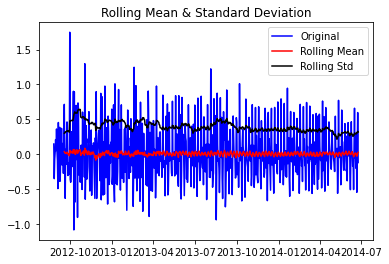

Results of Dickey-Fuller Test: 
Test Statistic            -8.237568e+00
P-value                    5.834049e-13
#lags used                 1.900000e+01
No of Observations used    6.480000e+02
Critical Value (1%)       -3.440482e+00
Critical Value (5%)       -2.866011e+00
Critical Value (10%)      -2.569151e+00
dtype: float64


In [105]:
# 对数时序数据求二阶差分后再迪基-福勒检验
train_log_diff = Train_log - Train_log.shift(1)
test_stationary(train_log_diff.dropna())

D:\software\Anaconda\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


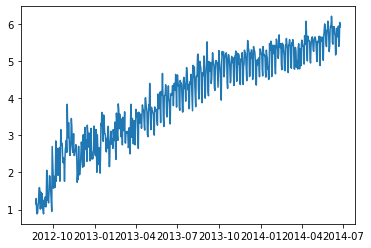

In [117]:
"""
季节性分解
对进行对数转换后的原始数据进行季节性分解。
"""
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.plot(Train_log, label='Original')
# plt.plot(trend, label='Trend')
# plt.plot(seasonal,label='Seasonality')
# plt.plot(residual, label='Residuals')

D:\software\Anaconda\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


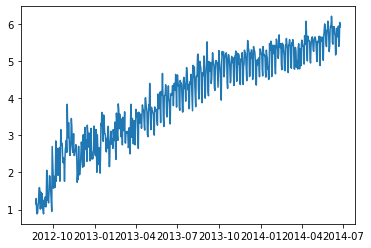

In [121]:
"""
季节性分解
对进行对数转换后的原始数据进行季节性分解。
"""
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.plot(Train_log, label='Original')
# plt.plot(trend, label='Trend')
# plt.plot(seasonal,label='Seasonality')
# plt.plot(residual, label='Residuals')

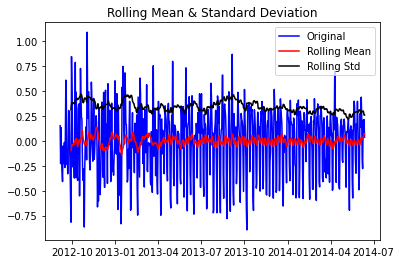

Results of Dickey-Fuller Test: 
Test Statistic            -7.822096e+00
P-value                    6.628321e-12
#lags used                 2.000000e+01
No of Observations used    6.240000e+02
Critical Value (1%)       -3.440873e+00
Critical Value (5%)       -2.866183e+00
Critical Value (10%)      -2.569243e+00
dtype: float64


In [122]:
# 对季节性分解后的残差数据进行迪基-福勒检验
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace=True)
train_log_decompose.dropna(inplace = True)
test_stationary(train_log_decompose[0])

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


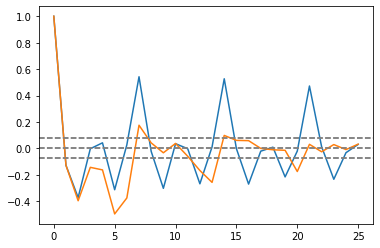

In [123]:
# 自相关和偏自相关图
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


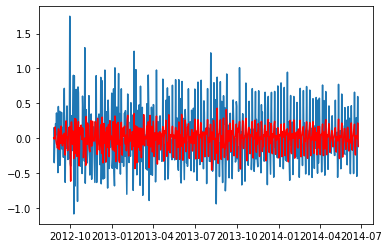

In [124]:
# AR模型
# AR模型训练及预测
model = ARIMA(Train_log, order = (2,1,0)) 
# 这里q值是零，因为它只是AR模型
results_AR = model.fit(disp = -1)
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_AR.fittedvalues, color='red', label='predictions')

Text(0.5, 1.0, 'RMSE: 43.9740')

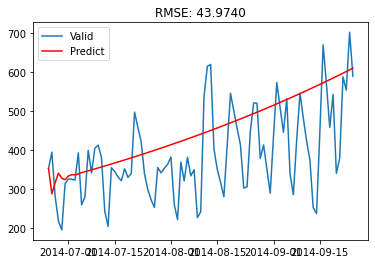

In [125]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25")
AR_predict=AR_predict.cumsum().shift().fillna(0)
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)
plt.plot(valid['Count'], label = "Valid")
plt.plot(AR_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))

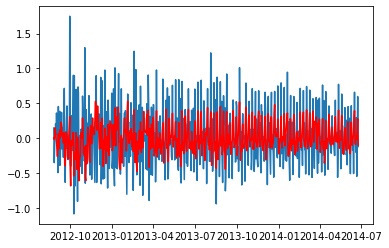

In [126]:
# MA模型
model = ARIMA(Train_log, order=(0, 1, 2))  
# 这里的p值是零，因为它只是MA模型
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_MA.fittedvalues, color='red', label='prediction')

Text(0.5, 1.0, 'RMSE: 43.2697')

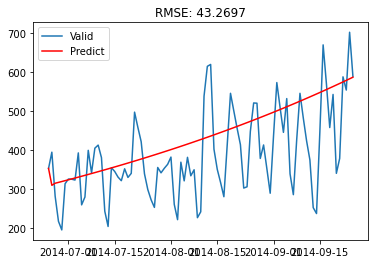

In [127]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)

plt.plot(valid['Count'], label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


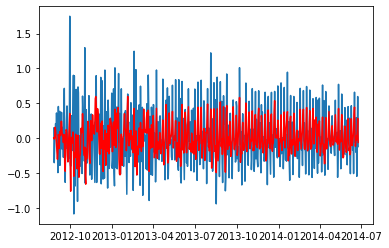

In [128]:
# ARMA模型
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted')

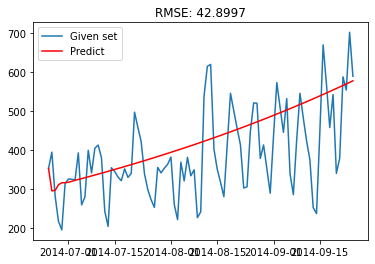

In [129]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))

def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25",
                                         end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, valid)

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


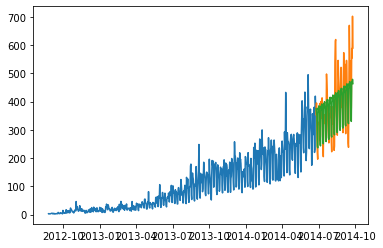

In [130]:
# SARIMAX模型
y_hat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True)
plt.plot( Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')

In [131]:
# 模型评价
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA))
print(rms)

70.2018731572278


In [133]:
# 预测
predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)
test['prediction']=predict
predict
# # 按日、月、年合并Test和test_original
# merge=pd.merge(test, test_org, on=('day','Month', 'Year'), how='left')
# merge['Hour']=merge['Hour_y']
# merge=merge.drop(['Year', 'Month', 'Datetime','Hour_x','Hour_y'], axis=1
# # 通过合并merge和temp2进行预测
# prediction=pd.merge(merge, temp2, on='Hour', how='left')
# # 将比率转换成原始比例
# prediction['Count']=prediction['prediction']*prediction['ratio']*24
# prediction['ID']=prediction['ID_y']
# submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)
# # 转换最终提交的csv格式
# pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2292: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


2014-09-26    451.952638
2014-09-27    343.170449
2014-09-28    338.003687
2014-09-29    478.632153
2014-09-30    472.616259
                 ...    
2015-04-22    717.199807
2015-04-23    702.033692
2015-04-24    690.197528
2015-04-25    581.415342
2015-04-26    576.248578
Freq: D, Name: predicted_mean, Length: 213, dtype: float64